#Energy Demand Forecasting in Spain

In [1]:
#import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!ls -l /content/gdrive/MyDrive/Project/Data_Project/Original_Data/Energy_Data

total 3215
-rw------- 1 root root 946953 Mar 16  2020  load_forecast_2016_2018.csv
-rw------- 1 root root 473123 Mar 16  2020 'Total Load - Day Ahead _ Actual_2015.csv'
-rw------- 1 root root 474463 Mar 16  2020 'Total Load - Day Ahead _ Actual_2016.csv'
-rw------- 1 root root 473173 Mar 16  2020 'Total Load - Day Ahead _ Actual_2017.csv'
-rw------- 1 root root 473173 Mar 16  2020 'Total Load - Day Ahead _ Actual_2018.csv'
-rw------- 1 root root 449407 Mar 16  2020 'Total Load - Day Ahead _ Actual_2019.csv'


In [ ]:
path = '/content/gdrive/MyDrive/Project/Data_Project/Original_Data/Energy_Data/'
files = ['Total Load - Day Ahead _ Actual_2015.csv',
            'Total Load - Day Ahead _ Actual_2016.csv',
            'Total Load - Day Ahead _ Actual_2017.csv',
            'Total Load - Day Ahead _ Actual_2018.csv',
            'Total Load - Day Ahead _ Actual_2019.csv']

In [ ]:
#load in list of the datasets
data_sets = [pd.read_csv(path+file) for file in files]

In [ ]:
#inital look at the unprocessed data
data_sets[0].head(10)

,Time (CET),Day-ahead Total Load Forecast [MW] - BZN|ES,Actual Total Load [MW] - BZN|ES
0,01.01.2015 00:00 - 01.01.2015 01:00,26118.0,25385.0
1,01.01.2015 01:00 - 01.01.2015 02:00,24934.0,24382.0
2,01.01.2015 02:00 - 01.01.2015 03:00,23515.0,22734.0
3,01.01.2015 03:00 - 01.01.2015 04:00,22642.0,21286.0
4,01.01.2015 04:00 - 01.01.2015 05:00,21785.0,20264.0
5,01.01.2015 05:00 - 01.01.2015 06:00,21441.0,19905.0
6,01.01.2015 06:00 - 01.01.2015 07:00,21285.0,20010.0
7,01.01.2015 07:00 - 01.01.2015 08:00,21545.0,20377.0
8,01.01.2015 08:00 - 01.01.2015 09:00,21443.0,20094.0
9,01.01.2015 09:00 - 01.01.2015 10:00,21560.0,20637.0


###Formatting Data

In [ ]:
# This function takes dataframe of actual and forecast loads and gives dataframe with a DatetimeIndex

def format_data(data):

    #change column names 
    data.columns = ['time', 'day_forecast', 'actual_load']

    #set the time to the first element in the time string. 
    #So 01.01.2018 00:00 - 01.01.2018 01:00 becomes 01.01.2018 00:00
    data['time'] = data['time'].str.split('-').apply(lambda x: x[0]).str.strip()
     
    #set the time strings to datetime obejects and set index as date time
    datetimes = pd.to_datetime(data['time'], format='%d-%m-%Y %H%M', errors='ignore')
    new_data = data.set_index(pd.DatetimeIndex(datetimes))
    
    #remove extra time column with original string objects
    data_time = new_data[['day_forecast', 'actual_load']]
    
    return data_time

In [ ]:
data_years = range(len(files))

#A dictionary of formatted dataframes where key is each year
format_sets = {year: format_data(data_set) for year,data_set in zip(data_years, data_sets)}

In [ ]:
#look of formatted data
format_sets[2].head()

,day_forecast,actual_load
time,,
2017-01-01 00:00:00,24255.0,24401.0
2017-01-01 01:00:00,23326.0,23393.0
2017-01-01 02:00:00,22287.0,21909.0
2017-01-01 03:00:00,21038.0,20615.0
2017-01-01 04:00:00,20079.0,19628.0


In [ ]:
# It combines data into single dataframe

def combine_yearly_data(dictionary):

    all_data_list = []
    
    for key in dictionary.keys():
        all_data_list.append(dictionary[key])
        
    data_all_years = pd.concat(all_data_list)
  
    return data_all_years

In [ ]:
data = combine_yearly_data(format_sets)

In [ ]:
print(data)

                    day_forecast actual_load
time                                        
2015-01-01 00:00:00      26118.0     25385.0
2015-01-01 01:00:00      24934.0     24382.0
2015-01-01 02:00:00      23515.0     22734.0
2015-01-01 03:00:00      22642.0     21286.0
2015-01-01 04:00:00      21785.0     20264.0
...                          ...         ...
2019-12-31 19:00:00            -           -
2019-12-31 20:00:00            -           -
2019-12-31 21:00:00            -           -
2019-12-31 22:00:00            -           -
2019-12-31 23:00:00            -           -

[43829 rows x 2 columns]


###Data Cleaning

In [ ]:
#check for NANs in the data
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43829 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   day_forecast  43819 non-null  object
 1   actual_load   43772 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


In [ ]:
#count the total nans in each column and the total length of the data.
data.isnull().sum(), len(data)

(day_forecast    10
 actual_load     57
 dtype: int64, 43829)

In [ ]:
#isolate the row indexes that with Nans
nan_load_data = data[data['actual_load'].isnull()==True].index
nan_forecast_data = data[data['day_forecast'].isnull()==True].index
(nan_load_data, nan_forecast_data)

(DatetimeIndex(['2015-02-01 07:00:00', '2015-02-01 08:00:00',
                '2015-02-01 09:00:00', '2015-02-01 12:00:00',
                '2015-02-01 13:00:00', '2015-02-01 14:00:00',
                '2015-02-01 15:00:00', '2015-02-01 16:00:00',
                '2015-02-01 17:00:00', '2015-02-01 18:00:00',
                '2015-02-01 19:00:00', '2015-01-28 13:00:00',
                '2015-05-02 10:00:00', '2015-10-02 08:00:00',
                '2015-10-02 11:00:00', '2015-12-02 09:00:00',
                '2015-03-29 02:00:00', '2015-04-16 09:00:00',
                '2015-04-20 08:00:00', '2015-04-23 21:00:00',
                '2015-01-05 12:00:00', '2015-01-05 13:00:00',
                '2015-01-05 14:00:00', '2015-01-05 15:00:00',
                '2015-01-05 16:00:00', '2015-01-05 17:00:00',
                '2015-04-05 03:00:00', '2015-05-29 03:00:00',
                '2016-03-27 02:00:00', '2016-04-25 05:00:00',
                '2016-04-25 07:00:00', '2016-07-09 22:00:00',
        

In [ ]:
# Fills the missing data in columns by linear interpolation

def fill_nans(data):

    try:
        data = data.astype(float)
    except:
        for char in ['-', '--', '?']:
            data = data.replace('-', np.nan)
        data = data.astype(float)
    
    data = data.interpolate(method='linear', axis=0)
    
    return data

In [ ]:
data = fill_nans(data)
data[data['actual_load'].isnull()==True]

,day_forecast,actual_load
time,,


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43829 entries, 2015-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   day_forecast  43829 non-null  float64
 1   actual_load   43829 non-null  float64
dtypes: float64(2)
memory usage: 1.0 MB


In [ ]:
# Interpreted values 
for t in nan_load_data:
    print(data[str(t)])

                     day_forecast  actual_load
time                                          
2015-02-01 07:00:00       24379.0      24710.5
                     day_forecast  actual_load
time                                          
2015-02-01 08:00:00       27389.0      27268.0
                     day_forecast  actual_load
time                                          
2015-02-01 09:00:00       30619.0      29825.5
                     day_forecast   actual_load
time                                           
2015-02-01 12:00:00       31357.0  32535.444444
                     day_forecast   actual_load
time                                           
2015-02-01 13:00:00       31338.0  32712.888889
                     day_forecast   actual_load
time                                           
2015-02-01 14:00:00       30874.0  32890.333333
                     day_forecast   actual_load
time                                           
2015-02-01 15:00:00       30124.0  33067.777778
 

In [73]:
print(len(data))

1461


In [74]:
# removes duplicate rows and outputs with its first occurance

def remove_duplicates(data):

    #find duplicated elements
    find_duplicated_rows = data.index.duplicated()
    
    #invert the array element wise
    keep_rows = np.invert(find_duplicated_rows)
    
    #return the original dataframe removing the duplicated values
    return data[keep_rows]

In [75]:
data = remove_duplicates(data)

In [76]:
# Save above data as csv
save_path = '/content/gdrive/MyDrive/Project/Data_Project/Processed Data/'
data.to_csv(save_path + 'load_forecast_2016_2018.csv')

###Data Cleaning

In [ ]:
#read in the dataframe
data = pd.read_csv('/content/gdrive/MyDrive/Project/Data_Project/Processed Data/load_forecast_2016_2018.csv', parse_dates=True, index_col='time')

In [3]:
# Transforms data into windowed data, here each row is a day and columns representing each hour as this way is easy to make hourly predictions 

def window_data(data, load_type='actual_load'):
    
    #from the original datetime index create new columns with each of the year, month, day, and hour.
    data.loc[:,'year'] = data.index.year
    data.loc[:,'month'] = data.index.month
    data.loc[:,'day'] = data.index.day
    data.loc[:,'hours'] = data.index.hour
    
    #construct datetimes from the split year, month, day columns
    data.loc[:,'date'] = pd.to_datetime(data.loc[:,['year', 'month', 'day']], format='%Y-%m-%d', errors='ignore')
    
    #set the index to dates only
    data = data.set_index(pd.DatetimeIndex(data['date']))
    
    #drop non-target columns 
    data = data.loc[:,[load_type, 'hours']]
    
    #pivot the table
    data = data.pivot(columns='hours', values=load_type)
    
    return data

In [ ]:
loads = window_data(data)
loads.head()

hours,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0
2015-01-03,25564.0,23584.0,22194.0,21296.0,21145.0,21316.0,21674.0,22127.0,22756.0,24654.0,...,26416.0,25362.0,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0
2015-01-04,25254.0,23620.0,22606.0,22191.0,21929.0,22195.0,24035.0,26807.0,28316.0,29871.0,...,28741.0,28249.0,28105.0,27908.0,27577.0,27418.0,28604.0,30346.0,28190.0,26270.0
2015-01-05,25069.0,23390.0,21988.0,21182.0,20778.0,20309.0,20252.0,19964.0,20796.0,22478.0,...,23340.0,22977.0,22614.0,22251.0,21888.0,22048.0,22858.0,25604.0,25381.0,23822.0


In [4]:
# plot the indivdual hours
def plot_hours(data, hour):
    
    #set figure size
    fig = plt.figure(figsize = (20,7))
    
    #select the hour to display
    display = data.iloc[:,hour]
    
    plt.plot(display.index, display.values)

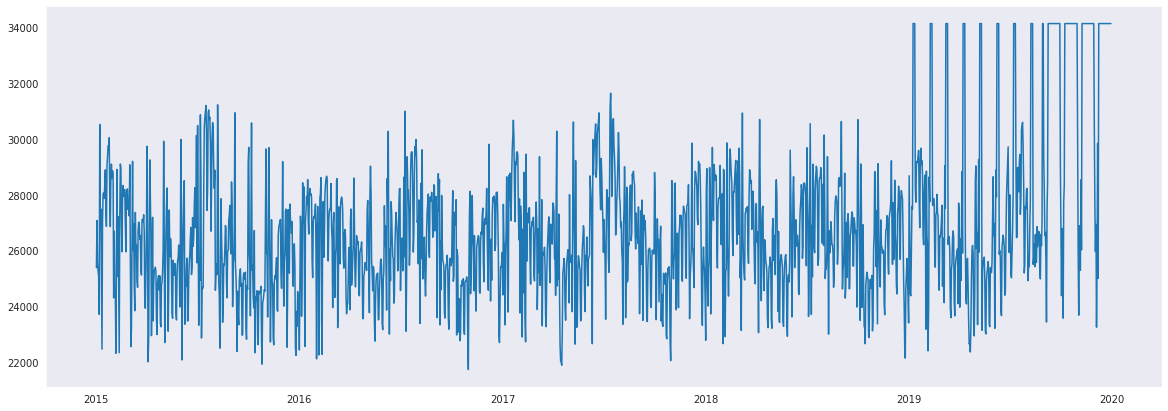

In [ ]:
#actual load readings at midnight.
plot_hours(loads, 0)

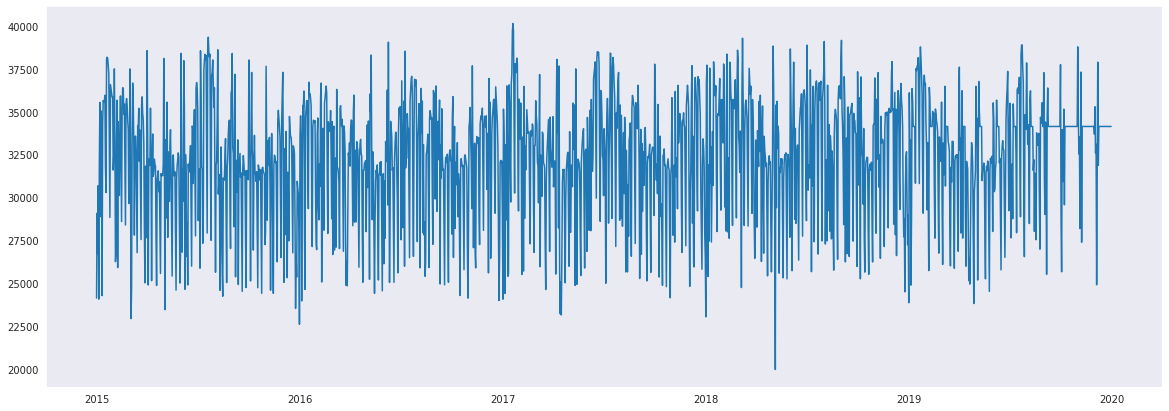

In [ ]:
# actual load readings at midday.
plot_hours(loads, 12)

In [5]:
def rename_cols(data, shift):
    
    cols = data.columns
    
    cols_list = []
    
    for idx, col in enumerate(cols):
        
        new_col = 't-' + str(shift) + ' h_' + str(idx)
        
        cols_list.append(new_col)
        
    data.columns = cols_list
    
    return data

###Data Analysis

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
#load the energy data
energy_data = pd.read_csv('/content/gdrive/MyDrive/Project/Data_Project/Processed Data/energy_loads_2015_2019.csv', parse_dates=True, index_col='time')

#remove the 2019 data because it is incomplete and will affect the distributions.
energy_data = energy_data['2015':'2018']

energy_data.head()

,day_forecast,actual_load
time,,
2015-01-01 00:00:00,26118.0,25385.0
2015-01-01 01:00:00,24934.0,24382.0
2015-01-01 02:00:00,23515.0,22734.0
2015-01-01 03:00:00,22642.0,21286.0
2015-01-01 04:00:00,21785.0,20264.0


In [ ]:
energy_data.describe()

,day_forecast,actual_load
count,35064.000000,35064.000000
mean,28712.354053,28698.592460
std,4593.742077,4575.338734
min,18105.000000,18041.000000
25%,24793.750000,24807.000000
50%,28906.000000,28902.000000
75%,32263.250000,32194.250000
max,41390.000000,41015.000000


In [ ]:
mean_absolute_error(energy_data['actual_load'], energy_data['day_forecast'])

316.892924366872

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


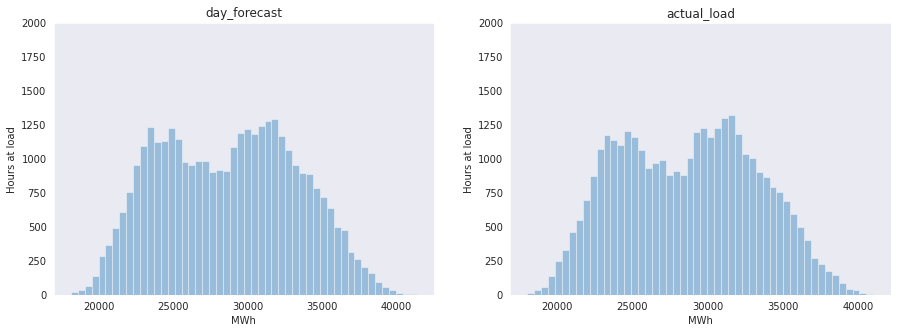

In [ ]:
#visualize the distributions

fig, axs = plt.subplots(1, 2, figsize=(15,5))

#cycle through subplots and columns
for ax, col in zip(axs, energy_data.columns):
    #histogram plot
    sns.distplot(energy_data[col], ax=ax, kde=False, hist=True)
    #set axis labels
    ax.set_title(col)
    ax.set_xlabel('MWh')
    ax.set_ylabel('Hours at load')
    #set the y labels
    ax.set_yticks(np.linspace(0, 2000, 9))
    
plt.show()

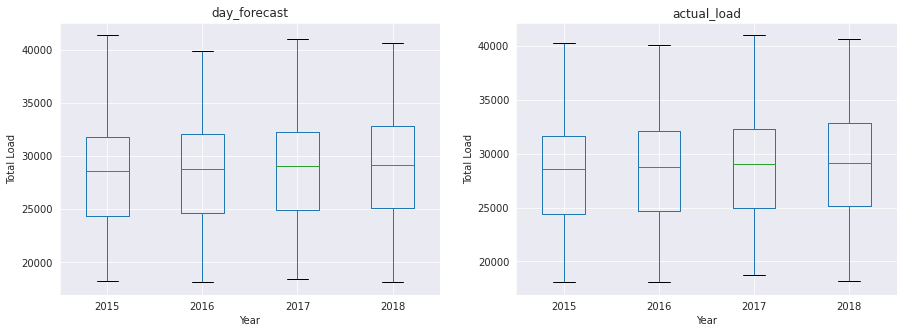

In [ ]:
#group the data into years for plotting

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, energy_data.columns):
    groups = energy_data[col].groupby(pd.Grouper(freq='A'))

    df = pd.DataFrame()

    for name, group in groups:
        df[name.year] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Year')
    ax.set_ylabel('Total Load')
    ax.set_title(col)

Above distribution shows a small trend of rising median actual load as we go from 2015 to 2018.

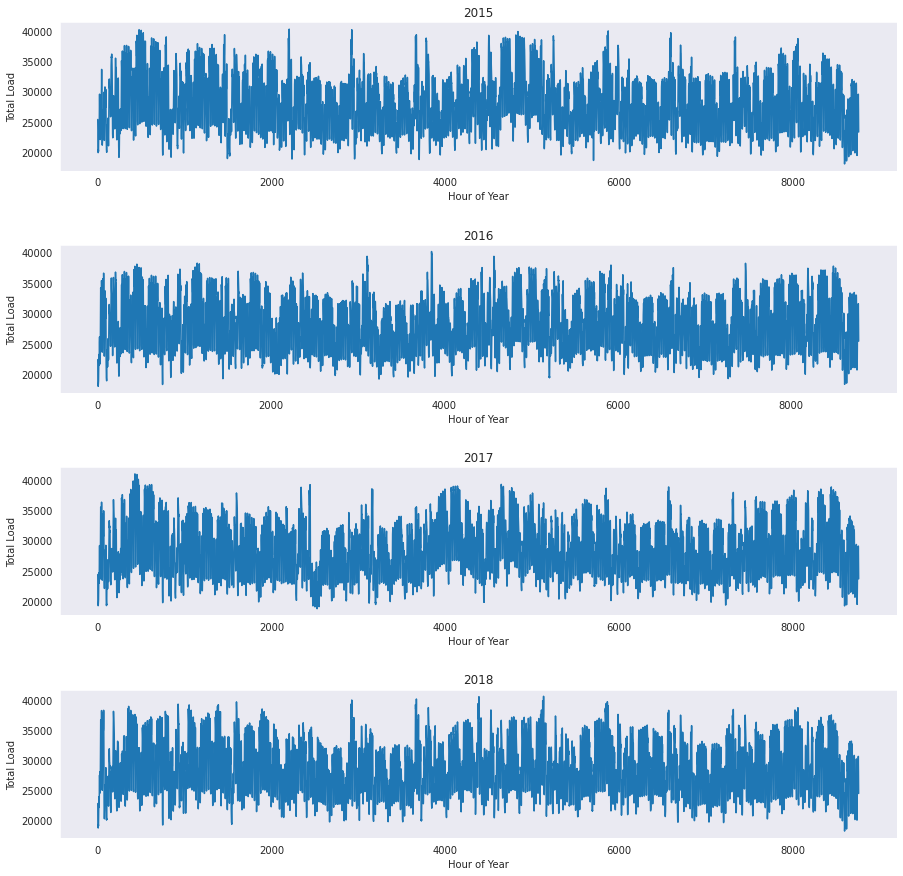

In [ ]:
# Plot the yearly actual loads

#group data by year
groups = energy_data['actual_load'].groupby(pd.Grouper(freq='A'))

#set figure and axis
fig, axs = plt.subplots(len(groups), 1, figsize=(15,15))


for ax, (name, group) in zip(axs, groups):
    
    #plot the data
    ax.plot(pd.Series(group.values))

    ax.set_xlabel('Hour of Year')
    ax.set_ylabel('Total Load')
    ax.set_title(name.year)
    plt.subplots_adjust(hspace=0.5)

Above plots shows variations in overall consumption during different times of a year.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


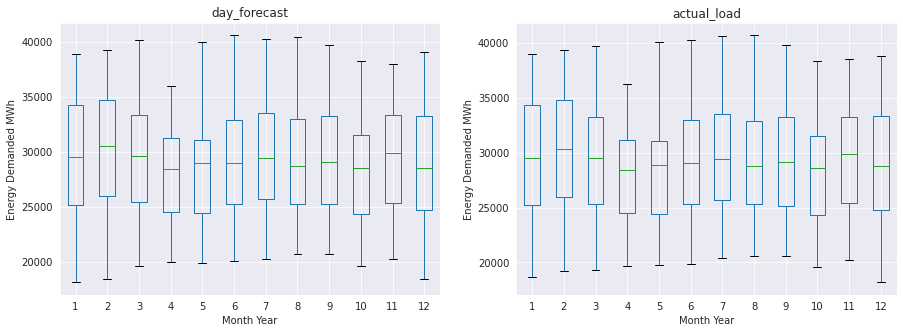

In [ ]:
# Plot the monthly data to see the seasonal effects

fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, energy_data.columns):
    
    groups = energy_data[col].groupby(pd.Grouper(freq='M'))
    
    df = pd.DataFrame()
    
    for name, group in groups:
        df[name.month] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Month Year')
    ax.set_ylabel('Energy Demanded MWh')
    ax.set_title(col)
    plt.subplots_adjust(hspace=0.5)
    
    
plt.show()

Actual loads throughout the year reveal definite seasonal patterns. The median actual load is highest in months 12,1,2 and 6,7,8. This indicates to winter and summer months as temperature fluctuates very much in these months. Therefore, we need to exlore weather data too and is seen further to find correlation.

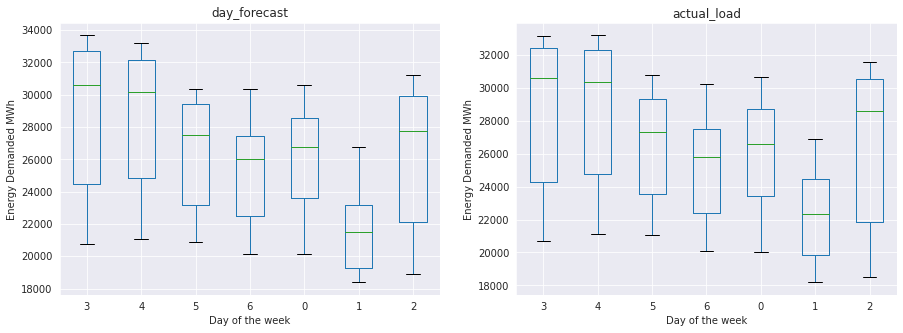

In [ ]:
# analysing weekly trends
fig, axs = plt.subplots(1, 2, figsize=(15,5))

for ax, col in zip(axs, energy_data.columns):
    
    groups = energy_data[col].groupby(pd.Grouper(freq='D'))
    
    df = pd.DataFrame()
    
    for name, group in groups:
        df[name.dayofweek] = pd.Series(group.values)

    df.boxplot(ax=ax)
    ax.set_xlabel('Day of the week')
    ax.set_ylabel('Energy Demanded MWh')
    ax.set_title(col)
    plt.subplots_adjust(hspace=0.5)
    
    
plt.show()

This shows that weekends has lower overall consumption.

In [ ]:
#transform the data into hourly windows
energy_data_transformed = window_data(energy_data)

#rename the columns
load_hourly = rename_cols(energy_data_transformed, shift=0)
load_hourly.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0


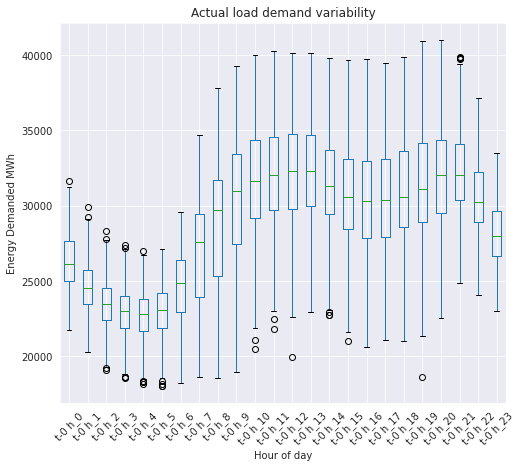

In [ ]:
fig = plt.figure(figsize=(8,7))
load_hourly.boxplot()
plt.xlabel('Hour of day')
plt.ylabel('Energy Demanded MWh')
plt.title('Actual load demand variability')
plt.xticks(rotation=45);

 Mean load profile is our target for forecasting. So plotting it :

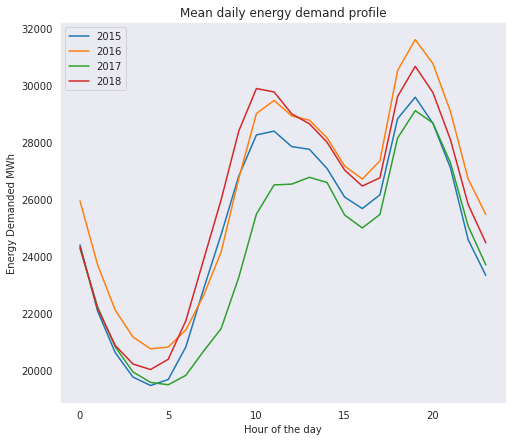

In [ ]:
group_hours = energy_data['actual_load'].groupby(pd.Grouper(freq='D', how='mean'))

fig, axs = plt.subplots(1,1, figsize=(8,7))

df = pd.DataFrame()
    
for name, group in group_hours:
    df[name.year] = pd.Series(group.values)

df.plot(ax=axs)
axs.set_xlabel('Hour of the day')
axs.set_ylabel('Energy Demanded MWh')
axs.set_title('Mean daily energy demand profile');

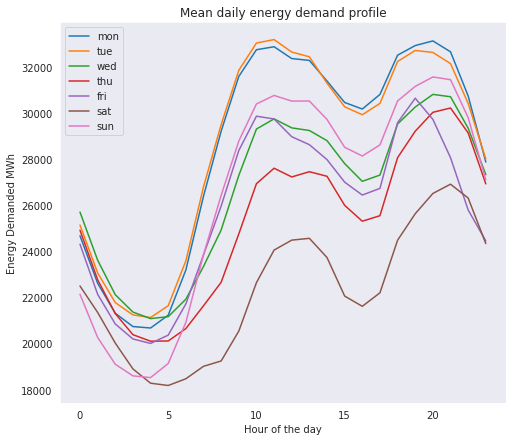

In [ ]:
#Weekly mean loads
group_hours = energy_data['actual_load'].groupby(pd.Grouper(freq='D', how='mean'))

days = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

fig, axs = plt.subplots(1,1, figsize=(8,7))

df = pd.DataFrame()
    
for name, group in group_hours:
    df[name.dayofweek] = pd.Series(group.values)

df.columns = days
df.plot(ax=axs)
axs.set_xlabel('Hour of the day')
axs.set_ylabel('Energy Demanded MWh')
axs.set_title('Mean daily energy demand profile');

We are forecasting 24 hours in advance that is we use hour 0 of yesterday to forecast hour 0 of today. So converting data into hourly and plotting them.

In [ ]:
#transform data and have a look.
hourly_plots = window_data(energy_data, 'actual_load')

#drop 2019 data
hourly_plots = hourly_plots[:'2018']
hourly_plots.tail(3)

hours,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2018-12-29,25709.0,23622.0,22122.0,21368.0,21084.0,21168.0,21927.0,23347.0,24931.0,27300.0,...,28811.0,27815.0,27044.0,27317.0,29535.0,30271.0,30819.0,30718.0,29352.0,27332.0
2018-12-30,24922.0,22772.0,21301.0,20386.0,20103.0,20112.0,20651.0,21639.0,22662.0,24759.0,...,27264.0,26002.0,25313.0,25552.0,28072.0,29221.0,30042.0,30229.0,29145.0,26934.0
2018-12-31,24312.0,22140.0,20851.0,20200.0,20006.0,20366.0,21723.0,23850.0,25969.0,28382.0,...,27988.0,27009.0,26449.0,26738.0,29592.0,30653.0,29735.0,28071.0,25801.0,24455.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


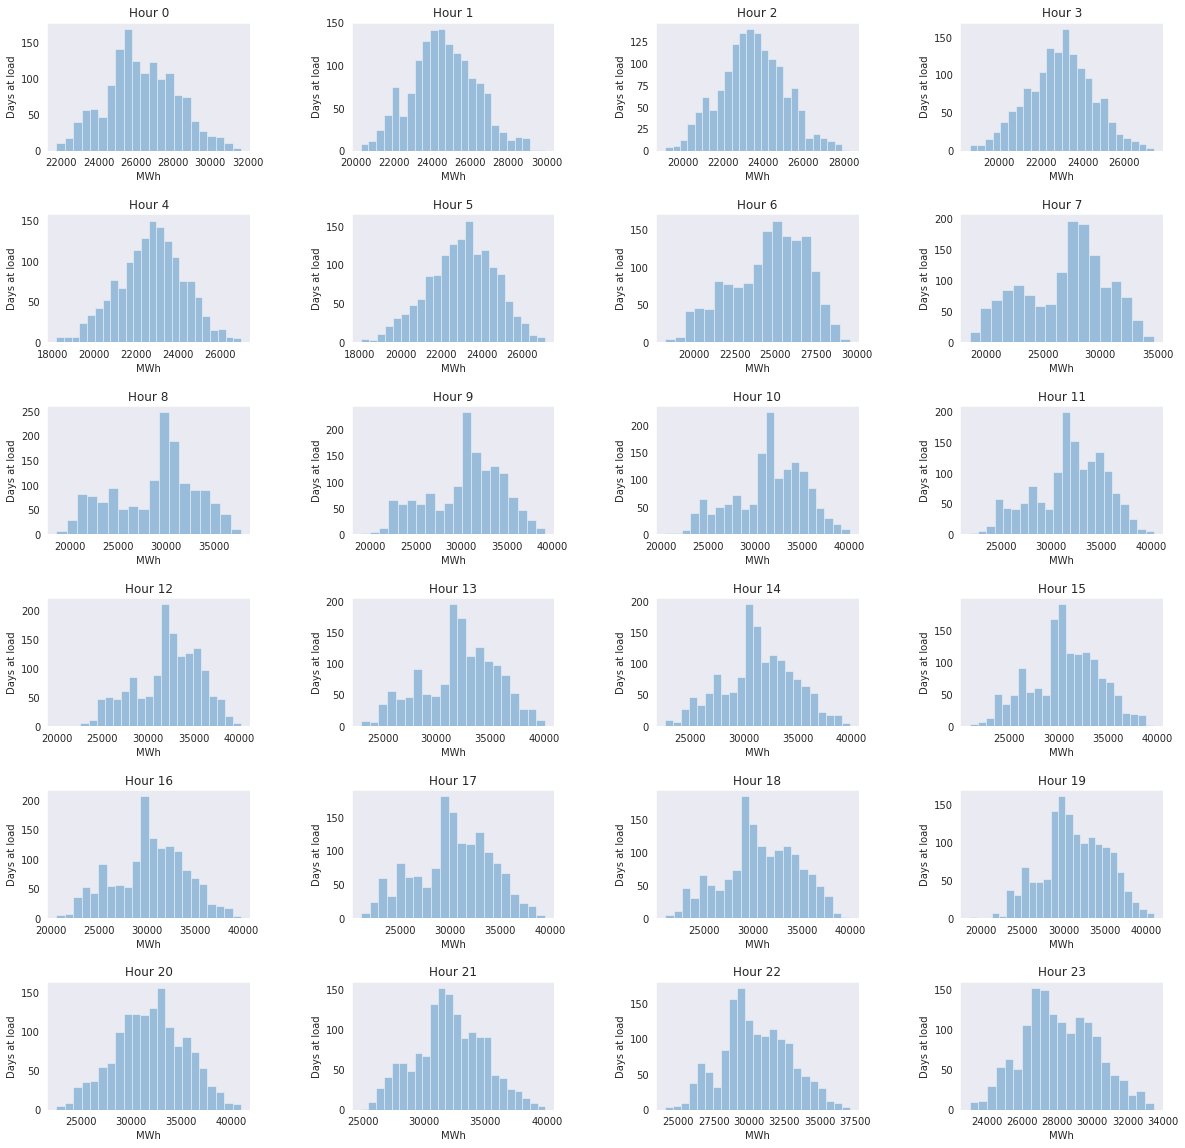

In [ ]:
# Plotting to see the hourly distributions and seasonality
fig, axs = plt.subplots(6, 4, figsize=(20,20))

#cycle through subplots and columns
for ax, col in zip(axs.flatten(), hourly_plots.columns):
    #histogram plot
    sns.distplot(hourly_plots[col], ax=ax, kde=False, hist=True)
    #set axis labels
    ax.set_title('Hour ' + str(col))
    ax.set_xlabel('MWh')
    ax.set_ylabel('Days at load')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
plt.show()

# Weather Data

It contains weather data for the 5 main cities in Spain.The data has hourly information on teperature, pressure, rainfall, cloud index, and weather descrption.

In [ ]:
#import data
path = '/content/gdrive/MyDrive/Project/Data_Project/weather_2013_2019.csv'
data_weather = pd.read_csv(path)

In [ ]:
data_weather.head(5)

,Unnamed: 0,dt,dt_iso,city_id,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,0,2013-10-01 02:00:00,2013-10-01 00:00:00 +0000 UTC,2509954,Valencia,299.150000,299.150000,299.150000,1008,61,5,290,0.0,0.0,0.0,20,801,clouds,few clouds,02n
1,1,2013-10-01 03:00:00,2013-10-01 01:00:00 +0000 UTC,2509954,Valencia,298.150000,298.150000,298.150000,1009,65,4,250,0.0,0.0,0.0,20,801,clouds,few clouds,02n
2,2,2013-10-01 04:00:00,2013-10-01 02:00:00 +0000 UTC,2509954,Valencia,296.161000,296.161000,296.161000,1009,71,4,269,0.0,0.0,0.0,10,800,clear,sky is clear,02
3,3,2013-10-01 05:00:00,2013-10-01 03:00:00 +0000 UTC,2509954,Valencia,297.150000,297.150000,297.150000,1008,69,1,250,0.0,0.0,0.0,20,801,clouds,few clouds,02n
4,4,2013-10-01 06:00:00,2013-10-01 04:00:00 +0000 UTC,2509954,Valencia,294.031687,294.031687,294.031687,1009,78,4,288,0.0,0.0,0.0,0,800,clear,sky is clear,01


In [ ]:
data_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263000 entries, 0 to 262999
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           263000 non-null  int64  
 1   dt                   263000 non-null  object 
 2   dt_iso               263000 non-null  object 
 3   city_id              263000 non-null  int64  
 4   city_name            263000 non-null  object 
 5   temp                 263000 non-null  float64
 6   temp_min             263000 non-null  float64
 7   temp_max             263000 non-null  float64
 8   pressure             263000 non-null  int64  
 9   humidity             263000 non-null  int64  
 10  wind_speed           263000 non-null  int64  
 11  wind_deg             263000 non-null  int64  
 12  rain_1h              263000 non-null  float64
 13  rain_3h              263000 non-null  float64
 14  snow_3h              263000 non-null  float64
 15  clouds_all       

In [ ]:
def clean_weather_data(data):
    
    #add city names
    city_codes = {3128760 : 'Barcelona', 
                  3117735 : 'Madrid', 
                  3128026 : 'Bilbao', 
                  2509954 : 'Valencia', 
                  6361046 : 'Seville'}
    
    data['city_name'] = data['city_id'].replace(city_codes)

    #drop all columns with only NaN values
    data = data.drop(['lat', 
                      'lon', 
                      'sea_level', 
                      'grnd_level', 
                      'rain_24h', 
                      'snow_today',
                      'rain_today', 
                      'snow_1h', 
                      'snow_24h'], axis=1)


    #convert timestamp to datetime object
    times = pd.to_datetime(data['dt'], unit='s', origin='unix')

    #convert the times to local time zone
    data['dt'] = times.dt.tz_localize('UTC').dt.tz_convert('Europe/Madrid').dt.strftime('%Y-%m-%d %H:%M:%S')

    #replace null values with zeros in columns with relevant informaiton
    nul_cols = ['rain_1h', 'rain_3h', 'snow_3h']
    data[nul_cols] = data[nul_cols].fillna(0)
    
    return data

In [ ]:
data_weather = clean_weather_data(data)

In [ ]:
data_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263000 entries, 0 to 262999
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           263000 non-null  int64  
 1   dt                   263000 non-null  object 
 2   dt_iso               263000 non-null  object 
 3   city_id              263000 non-null  int64  
 4   city_name            263000 non-null  object 
 5   temp                 263000 non-null  float64
 6   temp_min             263000 non-null  float64
 7   temp_max             263000 non-null  float64
 8   pressure             263000 non-null  int64  
 9   humidity             263000 non-null  int64  
 10  wind_speed           263000 non-null  int64  
 11  wind_deg             263000 non-null  int64  
 12  rain_1h              263000 non-null  float64
 13  rain_3h              263000 non-null  float64
 14  snow_3h              263000 non-null  float64
 15  clouds_all       

In [ ]:
#investigate values in the weather main
data_weather['weather_main'].value_counts(dropna=False)

clear           118166
clouds          107307
rain             24748
mist              4873
fog               3016
drizzle           2333
thunderstorm      1319
haze               491
dust               404
snow               297
smoke               43
sand                 1
tornado              1
squall               1
Name: weather_main, dtype: int64

In [ ]:
#investigate values in the weather main
data_weather['weather_description'].value_counts(dropna=False)

sky is clear                        113922
few clouds                           52151
broken clouds                        25835
scattered clouds                     24462
light rain                           15131
moderate rain                         5690
mist                                  4873
overcast clouds                       4859
clear sky                             4244
fog                                   3016
heavy intensity rain                  1719
light intensity drizzle               1613
light intensity shower rain            806
proximity shower rain                  572
shower rain                            560
proximity thunderstorm                 555
drizzle                                542
haze                                   491
thunderstorm                           440
dust                                   399
thunderstorm with rain                 170
very heavy rain                        161
light snow                             156
light inten

In [ ]:
#It sets the descrption columns to lower case, and removes special characters from the names.
def clean_descrption_cols(data):
    
    #make each element in the columns lowercase
    data[['weather_main', 'weather_description']] = data[['weather_main', 'weather_description']].apply(lambda x: x.str.lower())
    
    #remove spcial characters
    special_chars = [',', '/', ':', ';', '-']
    
    for char in special_chars:
        data['weather_description'] = data['weather_description'].str.replace(char,' ')
        
    return data

In [ ]:
data_weather = clean_descrption_cols(data)

In [ ]:
data_weather.head()

In [ ]:
data_weather.city_name.value_counts()

Here weather data is of 5 cities only whereas energy data is of whole country we need to make weather data to represent the entire Spain by taking weighted average of the cities  feature value based on population.

In [ ]:
populations = {'Madrid' : 3174000,
              ' Barcelona' : 1165000,
              'Bilbao' : 345000,
              'Seville' : 690000,
              'Valencia' : 789000}

#create a populations column
data_weather['population'] = [populations[city] for city in data_weather.city_name]

In [ ]:
num_cols = ['temp', 'pressure', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_3h']

#create dataframe to store the transformed data
national_weather = pd.DataFrame()

#for the numeric columns, group by datetime and average according to their population weight
for col in num_cols:
    #group by the datecolumn. for each element in the column average it by it's weight
    national_weather[col] = data_weather.groupby(data_weather.dt).apply(lambda x : np.average(x[col], weights=x.population))

In [ ]:
national_weather.index.min(), national_weather.index.max()

('2013-10-01 02:00:00', '2019-08-26 02:00:00')

In [ ]:
national_weather = national_weather.reset_index()

In [ ]:
national_weather.head(3)

,dt,temp,pressure,wind_speed,rain_1h,rain_3h,snow_3h
0,2013-10-01 02:00:00,293.616979,1008.499108,3.256044,0.000000,0.055979,0.0
1,2013-10-01 03:00:00,293.521288,1008.459192,3.195197,0.000000,0.055979,0.0
2,2013-10-01 04:00:00,293.025492,1008.336038,3.720104,0.033588,0.000000,0.0


In [ ]:
national_weather.shape

(51714, 7)

In [ ]:
#create separate set 
datetimes = pd.to_datetime(national_weather['dt'], format='%d-%m-%Y %H%M', errors='ignore')

national_weather = national_weather.set_index(pd.DatetimeIndex(datetimes))

In [ ]:
national_weather.to_csv('/content/gdrive/MyDrive/Project/Data_Project/Processed Data/national_weather_2013_2019_dtidx')

In [ ]:
weather_data = pd.read_csv('/content/gdrive/MyDrive/Project/Data_Project/Processed Data/national_weather_2013_2019_dtidx', parse_dates=True, index_col='dt')

weather_data.drop('dt.1', axis=1, inplace=True)

weather_data = weather_data['2015':'2018']

print(weather_data.index.min(), weather_data.index.max())
weather_data.head(3)

2015-01-01 00:00:00 2018-12-31 23:00:00


,temp,pressure,wind_speed,rain_1h,rain_3h,snow_3h
dt,,,,,,
2015-01-01 00:00:00,271.239327,998.190492,2.078209,0.0,0.0,0.0
2015-01-01 01:00:00,271.245271,998.134512,2.078209,0.0,0.0,0.0
2015-01-01 02:00:00,270.544537,998.507545,2.230083,0.0,0.0,0.0


In [ ]:
#combine the weather and energy dataframes in new df
data_energy_weather = energy_data.copy()

weather_cols = ['temp', 'pressure', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_3h']

#add the weather features
data_energy_weather[weather_cols] = weather_data[weather_cols]

#drop the day forecast feature
data_energy_weather.drop('day_forecast', axis=1, inplace=True)

data_energy_weather.head(3)

,actual_load,year,month,day,hours,date,temp,pressure,wind_speed,rain_1h,rain_3h,snow_3h
time,,,,,,,,,,,,
2015-01-01 00:00:00,25385.0,2015,1,1,0,2015-01-01,271.239327,998.190492,2.078209,0.0,0.0,0.0
2015-01-01 01:00:00,24382.0,2015,1,1,1,2015-01-01,271.245271,998.134512,2.078209,0.0,0.0,0.0
2015-01-01 02:00:00,22734.0,2015,1,1,2,2015-01-01,270.544537,998.507545,2.230083,0.0,0.0,0.0


In [ ]:
#calcualte the heat degree days
data_energy_weather['heatdd'] = 291.15 - data_energy_weather['temp']
#calcualte the cool degree days
data_energy_weather['cooldd'] = data_energy_weather['temp'] - 291.15

#set any values below 0
data_energy_weather[['heatdd', 'cooldd']] = data_energy_weather[['heatdd', 'cooldd']].clip(lower=0)

In [ ]:
# Save the energy + weather data as csv
data_energy_weather.to_csv('/content/gdrive/MyDrive/Project/Data_Project/Processed Data/energy_weather_2015_2018.csv')

###EDA

In [ ]:
import datetime as dt
from sklearn.metrics import mean_squared_error

In [6]:
def get_dataset(path='/content/gdrive/MyDrive/Project/Data_Project/energy_loads_2015_2019.csv', index='time', start='2015', stop='2018', shift=0):
    #load the preprocessed data
    data = pd.read_csv('/content/gdrive/MyDrive/Project/Data_Project/energy_loads_2015_2019.csv', parse_dates=True, index_col=index)

    #use features preprocessing library to transform data into day and hour slice format.
    data = window_data(data)

    #rename the columns
    data = rename_cols(data, shift=shift)

    #standardize the data from 2015-2018
    data = data[start:stop]

    return data

In [ ]:
data = get_dataset()

#save the dataset as persistance set
data.to_csv('/content/gdrive/MyDrive/Project/Data_Project/Processed Data/transform_2015_2018.csv')

#view the dataset and check the slicing
data.head(3)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0
2015-01-03,25564.0,23584.0,22194.0,21296.0,21145.0,21316.0,21674.0,22127.0,22756.0,24654.0,...,26416.0,25362.0,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0


In [ ]:
data.tail()

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-12-27,24679.0,22620.0,21316.0,20739.0,20676.0,21231.0,23195.0,26398.0,29222.0,31599.0,...,31399.0,30469.0,30184.0,30819.0,32522.0,32940.0,33142.0,32669.0,30753.0,27882.0
2018-12-28,25147.0,23068.0,21779.0,21244.0,21132.0,21642.0,23591.0,26804.0,29506.0,31863.0,...,31308.0,30281.0,29935.0,30428.0,32248.0,32728.0,32642.0,32155.0,30428.0,28015.0
2018-12-29,25709.0,23622.0,22122.0,21368.0,21084.0,21168.0,21927.0,23347.0,24931.0,27300.0,...,28811.0,27815.0,27044.0,27317.0,29535.0,30271.0,30819.0,30718.0,29352.0,27332.0
2018-12-30,24922.0,22772.0,21301.0,20386.0,20103.0,20112.0,20651.0,21639.0,22662.0,24759.0,...,27264.0,26002.0,25313.0,25552.0,28072.0,29221.0,30042.0,30229.0,29145.0,26934.0
2018-12-31,24312.0,22140.0,20851.0,20200.0,20006.0,20366.0,21723.0,23850.0,25969.0,28382.0,...,27988.0,27009.0,26449.0,26738.0,29592.0,30653.0,29735.0,28071.0,25801.0,24455.0


In [7]:
#function to split into training and test sets. Here rows are daily values and columns are hourly slices

def train_test_split(data, split_date='2017-12-31'):
    
    train = data[:split_date]
    split_date = dt.datetime.strptime(split_date, '%Y-%m-%d')

    #increment the split date by 1
    split_date += dt.timedelta(days=1)
    
    test = data[split_date:]
    
    return train, test

In [8]:

def walk_forward(model, train, test, model_name):
        
    #walk forward window
    data_history = train.copy()

    predictions = []
    
    #loop through each row in test from i to length of i
    for i in range(test.shape[0]):
        
        #get forecasted values from the model
        Y_hat = model(data_history)
        
        #store predictions
        predictions.append(Y_hat)
        
        #get real observation and append to the history for next step in walk forward.
        data_history.append(test.iloc[i,:])
    
    #store predictions in a dataframe
    predictions = pd.DataFrame(predictions, index = test.index, columns = test.columns)
    
    errors, error_mean = calculate_errors(predictions, test, model_name)
    
    return errors, error_mean

In [9]:
def calculate_errors(Y_hat_test, Y_test, result_set):
    
    #set a multi index to store and compare with other models
    columns = [result_set]
    
    error_list = []
    error_mean = []
    
    
    #calculate the mse and mae for each hour in the Y_test and Prediction
    for i in range(Y_hat_test.shape[1]):
        error_list.append([
            #calcualte the RMSE
            np.sqrt(mean_squared_error(Y_hat_test.iloc[:,i], Y_test.iloc[:,i]))
        ])

    #append average mean error of the predictions
    error_mean.append([
        np.mean(error_list[0])
    ])    
    
    
    #set an index with the 24 periods
    index = [str(x) for x in range(24)]
    
    #store errors in dataframe
    errors = pd.DataFrame(error_list, index=index, columns=columns)
    
    return errors, error_mean


In [10]:
# This takes dataframe of errors with headers RMSE, MAE and 24 periods from h_0 to h_23 and plots error metrices
def plot_error(errors, result_set=[], title=''):
  
    plt.figure(figsize=(8,7))
    
    #get values for the x label
    x_labels = errors.index
    
    for result in result_set:
        #call the plot
        plt.plot(x_labels, errors[result], label=result)

    #set the label names and title
    plt.ylabel('RMSE Error (MW)')
    plt.xlabel('Hour of day')
    plt.title(title)
    plt.legend()
    
    plt.show()

In [ ]:
def day_hbh(history, days=1):
    
    #retrns the last week in the history data set as the forecast for the next week.
    return history.iloc[-days,:]

In [ ]:
# set the train/test split as 0.75 to split first 3 years as train.
train, test =train_test_split(data, split_date='2017-12-31')

#check we are splitting in the right spot
train.index.max(), test.index.min()

(Timestamp('2017-12-31 00:00:00'), Timestamp('2018-01-01 00:00:00'))

In [ ]:
errors_day, error_mean_day = walk_forward(day_hbh, train, test, "prev_day_data")

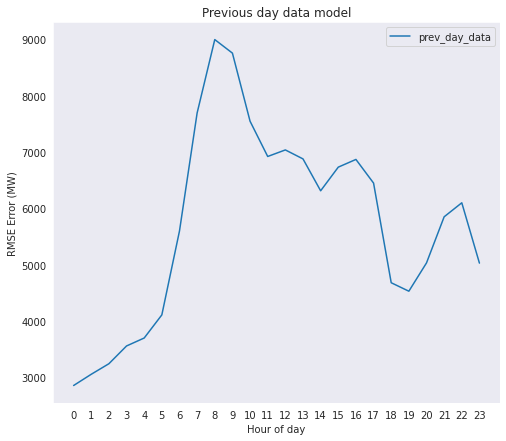

In [ ]:
plot_error(errors_day, result_set=['prev_day_data'], title='Previous day data model')

In [ ]:
errors_day.head(3)

,prev_day_data
0,2858.969991
1,3058.548695
2,3245.689512


In [13]:
def normalize_df(data):
    
    #normalize the dataset for working with the lstm nn
    scaler = MinMaxScaler().fit(data.values)
    data_normd = scaler.transform(data.values)

    data = pd.DataFrame(data_normd, index=data.index, columns=data.columns)
    
    return data, scaler

In [12]:
def sample_mape(actual, predicted):
    
    #calcualtes the mean absolute percent error per cross validated sample
    #returns as a percentage
    
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [11]:
def inspect_cv_predictions(actuals, predictions):

    #the number of cross validation sets
    plots = predictions.shape[0]
    
    #the first day, middle day, and last days of the validation set
    days = [1, int(predictions.shape[1]/2), predictions.shape[1]-1]
    
    #set figure
    fig, axs = plt.subplots(plots,3, figsize=(15,20))

    #loop through the samples then loop through the days
    for i, axe in zip(range(plots), axs):
        for day, ax in zip(days, axe):
            
            #plot the predictions
            ax.plot(predictions[i][day], label='predicted')
            #plot actual values
            ax.plot(actuals[i][day], label='actual')
            ax.set_title('Cross val set {}, sample day {}'.format(i,day))

    #position the legend in the top left position of the top left chart.
    axs[0][0].legend(loc=2)
    plt.subplots_adjust(hspace=0.3)

In [14]:
def cv_week_predictions(actuals, predictions, num_days=7, shift=0):

    #the number of cross validation sets
    plots = predictions.shape[0]
    
    #the first day, middle day, and last days of the validation set
    
    days = [x+shift for x in range(num_days)]
    #days = [1, int(predictions.shape[1]/2), predictions.shape[1]-1]
    
    #set figure
    fig, axs = plt.subplots(plots,1, figsize=(15,20))

    #loop through the samples then loop through the days
    for i, ax in zip(range(plots), axs):
        #for day, ax in zip(days, axe):
            
        #plot the predictions
        ax.plot(predictions[i][days].flatten(), label='predicted')
        #plot actual values
        ax.plot(actuals[i][days].flatten(), label='actual')
        ax.set_title('Cross val set {}'.format(i))
        ax.set_xlabel('Hours')
        ax.set_ylabel('MW')

        #position the legend in the top left position of the top left chart.
        axs[i].legend(loc='lower right')
    plt.subplots_adjust(hspace=0.3)

In [15]:
def get_sample_total_mae(actual, predicted):
    #list to save scores
    maes = []
    mapes = []

    #loop through each crossvalidation sample
    for i in range(actual.shape[0]):
        
        #calcualte the mae and save to list
        mae = mean_absolute_error(actual[i], predicted[i])
        mape = sample_mape(actual[i], predicted[i])
        
        maes.append(mae)
        mapes.append(mape)
        print('Sample {} total MAE {:.2f}, MAPE {:.2f}%'.format(i,mae, mape))
        
    maes_total = np.mean(maes)
    mape_total = np.mean(mapes)
    
    print('Mean crossvalidation MAE {:.2f} MAPE {:.2f}%'. format(maes_total, mape_total))
        
    return maes, mapes

In [16]:
def split_sequences(sequences, n_steps, extra_lag=False, long_lag_step=7, max_step=30, idx=0, multivar=False):
    
    #if not adding extra lag features adjust max_step and n_steps to aling
    if not extra_lag:
        max_step=n_steps
        n_steps+=1
        
    
    X, y = list(), list()
    for i in range(len(sequences)):
        
        # find the end of this pattern
        #end_ix = i + n_steps
        end_ix = i + max_step
        
        #create a list with the indexes we want to include in each sample
        slices = [x for x in range(end_ix-1,end_ix-n_steps, -1)] + [y for y in range(end_ix-n_steps, i, -long_lag_step)]
        
        #reverse the slice indexes
        slices = list(reversed(slices))
        
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break


        # gather input and output parts of the pattern
        seq_x = sequences[slices, :]
        seq_y = sequences[end_ix, :]

        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)
    
    if multivar:
        #unstack the 3rd dimension and select the first element(energy load)
        y = y[:,idx]
    
    return X, y

In [ ]:
from datetime import date
import pandas as pd
import holidays

In [ ]:
def get_holidays(start='1/1/2018', stop='31/12/2018', country='ES', frequency='H'):
    
    #generate the range of daily dates
    dates = pd.date_range(start=start, end=stop, freq=frequency)
    
    #create the holiday object
    country_holidays = holidays.CountryHoliday(country)

    #create a list for the holiday bool and name
    holiday_list = []
    
    #loop through the dates
    for date in dates:
        #true if holiday in object, false otherwise
        holiday_bool = date in country_holidays
        holiday_names = country_holidays.get(date)
        
        holiday_list.append([holiday_bool, holiday_names])
        
    #create return dataframe
    holidays_data = pd.DataFrame(holiday_list, index=dates, columns=['holiday_bool', 'holiday_name'])
                  
    return holidays_data


In [ ]:
def get_days_dummies(start='1/1/2018', stop='31/12/2018', frequency='H'):
    
    
    #generate the range of daily dates
    dates = pd.date_range(start=start, end=stop, freq=frequency)
    
    #create a dataframe of weekday categories
    days = pd.DataFrame(list(dates.weekday), index=dates, columns=['weekday_id'])
    
    days = pd.get_dummies(days['weekday_id'])
    
    columns = ['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun']
    
    days.columns = columns
    
    return days

#1. LSTM

In [ ]:
import keras
import tensorflow
from keras.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
data_energy_weather = pd.read_csv('/content/gdrive/MyDrive/Project/Data_Project/Processed Data/energy_weather_2015_2018.csv', parse_dates=True, index_col='time')
data_energy_weather.head(3)

,actual_load,year,month,day,hours,date,temp,pressure,wind_speed,rain_1h,rain_3h,snow_3h,heatdd,cooldd
time,,,,,,,,,,,,,,
2015-01-01 00:00:00,25385.0,2015,1,1,0,2015-01-01,271.239327,998.190492,2.078209,0.0,0.0,0.0,19.910673,0.0
2015-01-01 01:00:00,24382.0,2015,1,1,1,2015-01-01,271.245271,998.134512,2.078209,0.0,0.0,0.0,19.904729,0.0
2015-01-01 02:00:00,22734.0,2015,1,1,2,2015-01-01,270.544537,998.507545,2.230083,0.0,0.0,0.0,20.605463,0.0


In [ ]:
data_energy_weather.index.min(), data_energy_weather.index.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2018-12-31 23:00:00'))

In [ ]:
days_df = get_days_dummies(start='2015-01-01', stop='2018-12-31', frequency='H')
days_df.head(3)

,mon,tue,wed,thur,fri,sat,sun
2015-01-01 00:00:00,0,0,0,1,0,0,0
2015-01-01 01:00:00,0,0,0,1,0,0,0
2015-01-01 02:00:00,0,0,0,1,0,0,0


In [ ]:
days_df.index.min(), days_df.index.max()

(Timestamp('2015-01-01 00:00:00', freq='H'),
 Timestamp('2018-12-31 00:00:00', freq='H'))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline

In [ ]:
## apply PCA pipeline to the weather features.

#initate a min max scaler
minmax = MinMaxScaler()

#initate a PCA object to cpature 90% of dimensionality
pca = PCA(n_components=2)

#initate the pipeline for pca
pca_pipe = make_pipeline(pca, minmax)

minmax_pipe = make_pipeline(minmax)

weather_cols = ['temp','pressure','wind_speed','rain_1h','rain_3h','snow_3h','heatdd','cooldd']

#select the weather columns and make sure there are no Nans before transform
data_weather = data_energy_weather[weather_cols].interpolate(method='linear')

#transform the weather data
pca_weather = pca_pipe.fit_transform(data_weather)

#make dataframe with the transformed weather pca
pca_weather_df = pd.DataFrame(pca_weather, index=data_weather.index, columns=['pca1', 'pca2'])

In [ ]:
pca_weather_df.head(3)

,pca1,pca2
time,,
2015-01-01 00:00:00,0.000932,0.051902
2015-01-01 01:00:00,0.000932,0.052050
2015-01-01 02:00:00,0.000933,0.034670


In [ ]:
pca_weather_df.index.max()

Timestamp('2018-12-31 23:00:00')

In [ ]:
all_data = pd.concat([data_energy_weather['actual_load'], pca_weather_df, days_df], axis=1)
all_data.head(3)

,actual_load,pca1,pca2,mon,tue,wed,thur,fri,sat,sun
2015-01-01 00:00:00,25385.0,0.000932,0.051902,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-01-01 01:00:00,24382.0,0.000932,0.052050,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-01-01 02:00:00,22734.0,0.000933,0.034670,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
all_data.to_csv('/content/gdrive/MyDrive/Project/Data_Project/Processed Data/all_dataset_2015_2018.csv')

We have used multivariate case for LSTM that uses past energy demand, weather features (temperature, humidity, wind speed, rain, etc), and day of the week as predictors. Fot this model:
INPUT (samples, lags & features, hourly slices) and
OUTPUT (samples, hourly slices)

In [ ]:
###define an LSTM model
def lstm_multivariate(n_lags, n_hours, cells=50, learning_rate=5e-3):
    
    #define the model
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(cells, activation='relu', return_sequences=True, input_shape=(n_lags, n_hours)))
    model.add(keras.layers.LSTM(int(cells/2), activation='relu'))
    model.add(keras.layers.Dense(n_hours))
    
    #define the learning rate
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    #compile model
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

In [ ]:
# function to take data and transform into 3d
def get_lstm_multivariable_data_3d(start='2015-01-01', stop='2015-01-05', n_lags=2, extra_lag=False, long_lag_step=7, max_lookback=30):

    #load in the prepared dataset
    all_data = pd.read_csv('/content/gdrive/MyDrive/Project/Data_Project/Processed Data/all_dataset_2015_2018.csv', parse_dates=True, index_col=0)

    #select data time slice
    data = all_data[start: stop].copy()
    
    #reshape the energy load columns for minmax scaling
    energy = data['actual_load'].values.reshape(-1,1)
    
    #minmax scale the energy column
    scaler = MinMaxScaler().fit(energy)
    data_normd = scaler.transform(energy)
    
    #reset the energy column to the actual loads
    data['actual_load'] = data_normd.copy()
    
    #create single columns with time features
    data.loc[:,'year'] = data.index.year
    data.loc[:,'month'] = data.index.month
    data.loc[:,'day'] = data.index.day
    data.loc[:,'hours'] = data.index.hour
    
    hours_tup = [] 

    #for each unique hour isolate the features and dates
    for h in data.hours.unique():
        
        #boolean mask for each hour of the day
        hour = data[data.hours==h].copy()
        #drop the unneeded columns
        hour.drop(['year', 'month', 'day', 'hours'], axis=1, inplace=True)
        #reshape 2D into a 3D matrix for stacking
        hour = np.reshape(hour.values, (hour.shape[0], hour.shape[1], 1))
        #append each 3d slice into list
        hours_tup.append(hour)
    
    
    tup = tuple(hours_tup)
    
    #stack all the 3D arrays into 1 single 3D array
    hours_stacked = np.dstack(tup)
    
    #make samples from hours stacked. result is 4D and 2D
    X_4d, y = split_sequences(hours_stacked, 
                           n_lags, 
                           extra_lag=extra_lag, 
                           long_lag_step=long_lag_step, 
                           max_step=max_lookback, 
                           idx=0, 
                           multivar=True)    
    X = []

    #flatten the 2nd and 3rd dimensions together to have a final array of samples, lags & features, hours
    for j in range(len(X_4d)):
        #reshape the inner dimensions
        n = X_4d[j].reshape(-1, hours_stacked.shape[-1])
        X.append(n)
    
    X = np.array(X)
    
    
    return X, y, scaler

In [ ]:
def run_multivariate_lstm(n_lags=2, n_crossvals=2, epochs=5, lr = 1e-3, extra_lag=False, long_lag_step=7, max_lookback=30, show_verbose=False, period_start = '2017-01-01', period_end = '2017-12-31'):

    n_hours = 24
    #load the inital data
    X_multi, y_multi, scaler_multi = get_lstm_multivariable_data_3d(start=period_start, 
                                                                    stop=period_end, 
                                                                    n_lags=n_lags, 
                                                                    extra_lag=extra_lag, 
                                                                    long_lag_step=long_lag_step, 
                                                                    max_lookback=max_lookback)


    n_features = X_multi.shape[1]


    if show_verbose:
        verbose = 1
    else:
        verbose = 0

    print('Crossvalidation run congifuration:')
    print('Number of crossvalidations: {}' .format(n_crossvals))
    print('Number of total feature vectors: {}' .format(n_features))
   
    print(X_multi.shape)
    print(y_multi.shape)

    #creates set sequences of the time series to cross validate on. 
    tscv = TimeSeriesSplit(n_splits=n_crossvals)

    #initalize lists to capture the output
    predictions = []
    actuals = []

    #run the LSTM model on each of the time series splits
    for train, test in tscv.split(X_multi, y_multi):

        lstm_multi = lstm_multivariate(n_features, n_hours, learning_rate=lr)

        lstm_multi.fit(X_multi[train], y_multi[train], epochs=epochs, verbose=verbose, shuffle=False)

        predict = lstm_multi.predict(X_multi[test], verbose=verbose)

        #inverse transform the predictions and actual values
        prediction = scaler_multi.inverse_transform(predict)
        actual = scaler_multi.inverse_transform(y_multi[test].copy())

        #save the results in a list
        predictions.append(prediction)
        actuals.append(actual)

    #convert results to numpy array for easy manipulation
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    print(predictions.shape)
    print(actuals.shape)
    #calculate and display the crossvalidated mean average errors 
    mae = get_sample_total_mae(actuals, predictions)

    #print a selection of the cross validated predictions. See how the sample predictions evolved.
    inspect_cv_predictions(actuals, predictions)


Crossvalidation run congifuration:
Number of crossvalidations: 2
Number of total feature vectors: 20
(363, 20, 24)
(363, 24)
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


4/4 [==============================] - 4s 24ms/step - loss: 0.8303
Epoch 2/50
4/4 [==============================] - 0s 25ms/step - loss: 0.3705
Epoch 3/50
4/4 [==============================] - 0s 23ms/step - loss: 0.3662
Epoch 4/50
4/4 [==============================] - 0s 22ms/step - loss: 0.3236
Epoch 5/50
4/4 [==============================] - 0s 24ms/step - loss: 0.2775
Epoch 6/50
4/4 [==============================] - 0s 29ms/step - loss: 0.2219
Epoch 7/50
4/4 [==============================] - 0s 23ms/step - loss: 0.1863
Epoch 8/50
4/4 [==============================] - 0s 26ms/step - loss: 0.1529
Epoch 9/50
4/4 [==============================] - 0s 24ms/step - loss: 0.1278
Epoch 10/50
4/4 [==============================] - 0s 23ms/step - loss: 0.1261
Epoch 11/50
4/4 [==============================] - 0s 29ms/step - loss: 0.1215
Epoch 12/50
4/4 [==============================] - 0s 25ms/step - loss: 0.1171
Epoch 13/50
4/4 [==============================] - 0s 27ms/step - loss: 

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


8/8 [==============================] - 3s 23ms/step - loss: 0.4316
Epoch 2/50
8/8 [==============================] - 0s 24ms/step - loss: 0.2959
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.1517
Epoch 4/50
8/8 [==============================] - 0s 24ms/step - loss: 0.1315
Epoch 5/50
8/8 [==============================] - 0s 25ms/step - loss: 0.1150
Epoch 6/50
8/8 [==============================] - 0s 23ms/step - loss: 0.1196
Epoch 7/50
8/8 [==============================] - 0s 26ms/step - loss: 0.1131
Epoch 8/50
8/8 [==============================] - 0s 24ms/step - loss: 0.1185
Epoch 9/50
8/8 [==============================] - 0s 24ms/step - loss: 0.1115
Epoch 10/50
8/8 [==============================] - 0s 25ms/step - loss: 0.1166
Epoch 11/50
8/8 [==============================] - 0s 24ms/step - loss: 0.1099
Epoch 12/50
8/8 [==============================] - 0s 26ms/step - loss: 0.1127
Epoch 13/50
8/8 [==============================] - 0s 25ms/step - loss: 

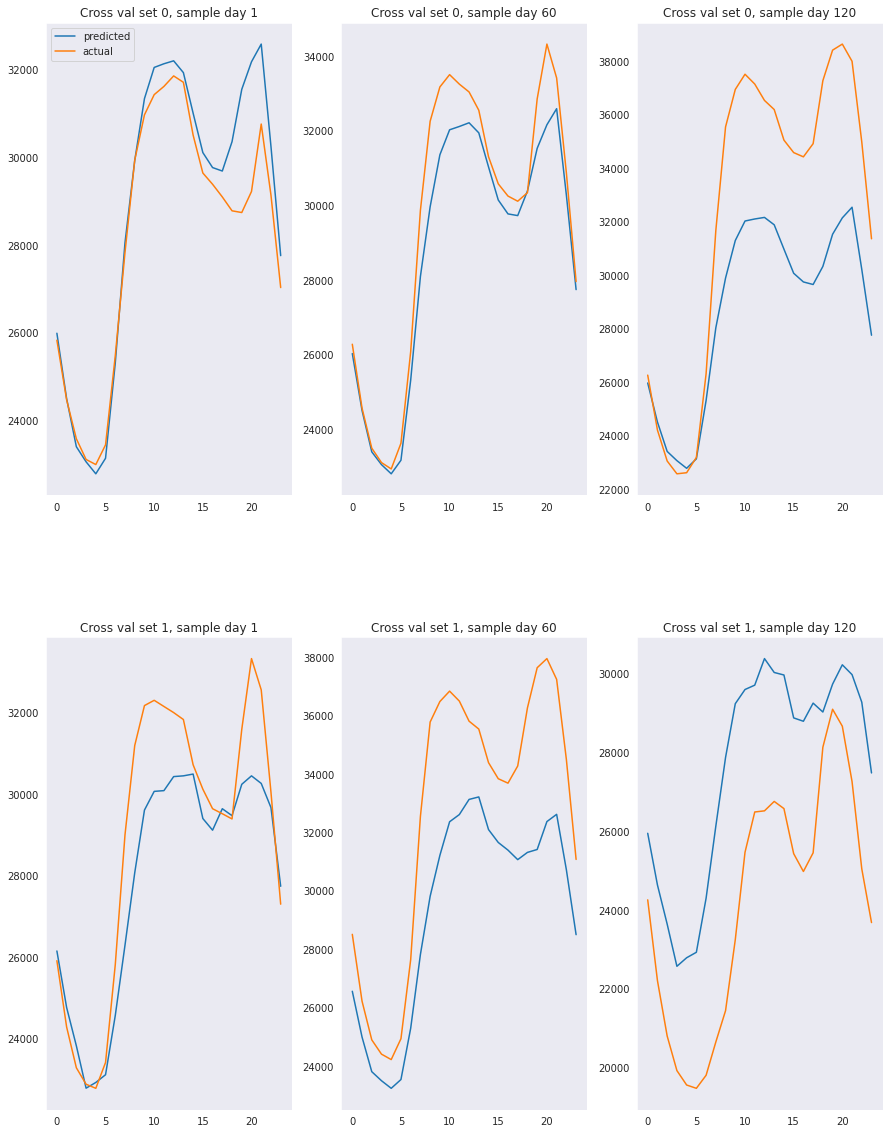

In [ ]:
run_multivariate_lstm(n_lags=2, 
                        n_crossvals=2, 
                        epochs=50, 
                        lr = 1e-2, 
                        show_verbose=True, 
                        period_start = '2017-01-01', 
                        period_end = '2017-12-31')

Crossvalidation run congifuration:
Number of crossvalidations: 2
Number of total feature vectors: 180
(275, 180, 24)
(275, 24)
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [==============================] - 3s 153ms/step - loss: 0.4295
Epoch 2/50
3/3 [==============================] - 0s 150ms/step - loss: 0.4160
Epoch 3/50
3/3 [==============================] - 0s 157ms/step - loss: 0.3986
Epoch 4/50
3/3 [==============================] - 1s 170ms/step - loss: 0.3738
Epoch 5/50
3/3 [==============================] - 0s 153ms/step - loss: 0.3405
Epoch 6/50
3/3 [==============================] - 0s 138ms/step - loss: 0.3277
Epoch 7/50
3/3 [==============================] - 0s 151ms/step - loss: 0.3070
Epoch 8/50
3/3 [==============================] - 0s 130ms/step - loss: 0.2882
Epoch 9/50
3/3 [==============================] - 0s 127ms/step - loss: 0.2669
Epoch 10/50
3/3 [==============================] - 0s 127ms/step - loss: 0.2484
Epoch 11/50
3/3 [==============================] - 0s 126ms/step - loss: 0.2318
Epoch 12/50
3/3 [==============================] - 0s 144ms/step - loss: 0.2170
Epoch 13/50
3/3 [==============================] - 0s 143ms/

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


6/6 [==============================] - 5s 278ms/step - loss: 0.4247
Epoch 2/50
6/6 [==============================] - 2s 310ms/step - loss: 0.3593
Epoch 3/50
6/6 [==============================] - 1s 195ms/step - loss: 0.3056
Epoch 4/50
6/6 [==============================] - 1s 130ms/step - loss: 0.2631
Epoch 5/50
6/6 [==============================] - 1s 131ms/step - loss: 0.2289
Epoch 6/50
6/6 [==============================] - 1s 130ms/step - loss: 0.2095
Epoch 7/50
6/6 [==============================] - 1s 152ms/step - loss: 0.1724
Epoch 8/50
6/6 [==============================] - 1s 156ms/step - loss: 0.1482
Epoch 9/50
6/6 [==============================] - 1s 152ms/step - loss: 0.1298
Epoch 10/50
6/6 [==============================] - 1s 151ms/step - loss: 0.1144
Epoch 11/50
6/6 [==============================] - 1s 149ms/step - loss: 0.1047
Epoch 12/50
6/6 [==============================] - 1s 149ms/step - loss: 0.1001
Epoch 13/50
6/6 [==============================] - 1s 142ms/

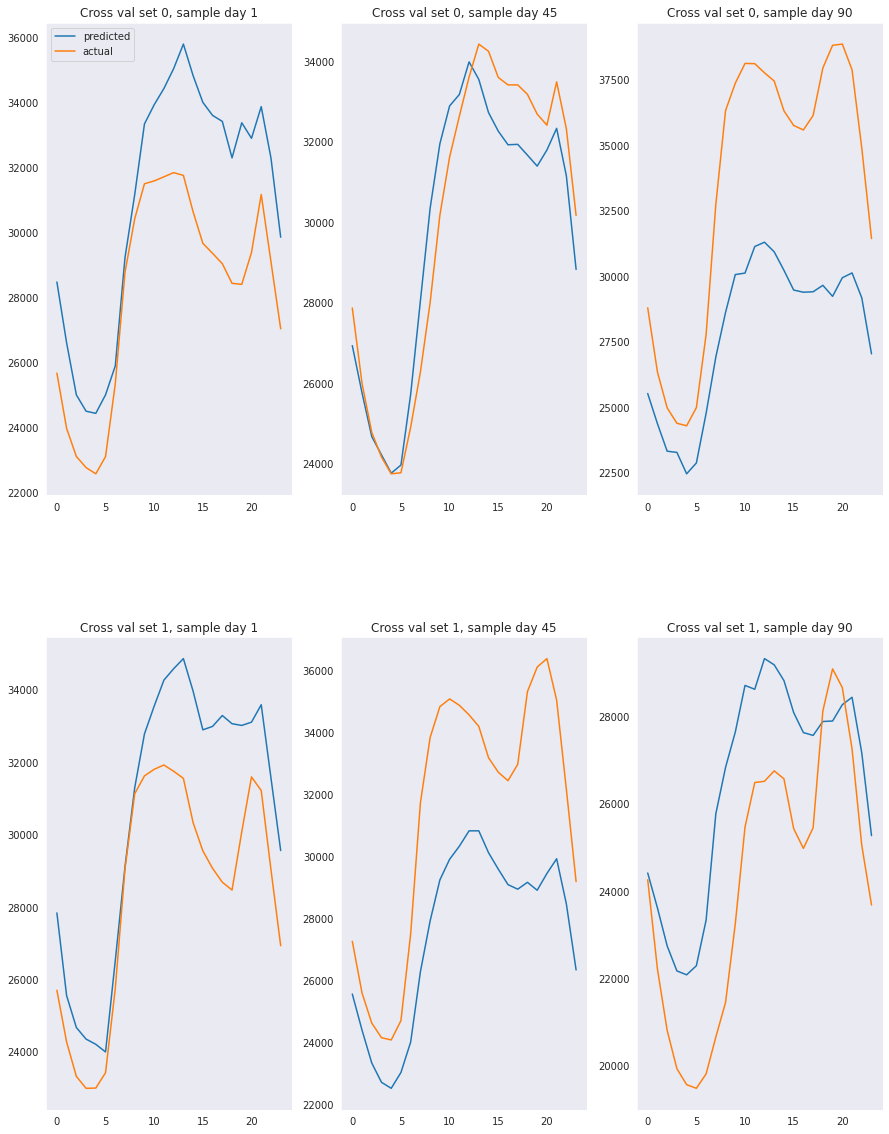

In [ ]:
run_multivariate_lstm(n_lags=7, 
                        n_crossvals=2, 
                        epochs=50, 
                        lr = 1e-3, 
                        extra_lag=True, 
                        long_lag_step=7, 
                        max_lookback=90, 
                        show_verbose=True, 
                        period_start = '2017-01-01', 
                        period_end = '2017-12-31')

In [ ]:
def rescale_results(data, scaler):
    #function rescales the data so when calcualting RMSE we have comparable metrics
    
    return scaler.inverse_transform(data)

In [ ]:
 #convert the numpy results back to a dataframe so we can use the calculate_errors function
def convert_df(result, test):

    y_cols = ['t-0 h_0', 't-0 h_1', 't-0 h_2', 't-0 h_3', 't-0 h_4', 't-0 h_5',
       't-0 h_6', 't-0 h_7', 't-0 h_8', 't-0 h_9', 't-0 h_10', 't-0 h_11',
       't-0 h_12', 't-0 h_13', 't-0 h_14', 't-0 h_15', 't-0 h_16', 't-0 h_17',
       't-0 h_18', 't-0 h_19', 't-0 h_20', 't-0 h_21', 't-0 h_22', 't-0 h_23']
    
    index = test.index
    
    return pd.DataFrame(result, index=index, columns=y_cols)

In [ ]:

Y_hat_test_df = convert_df(rescale_results(Y_hat_test, scaler), test)
Y_test_df = convert_df(rescale_results(Y_test, scaler), test)

In [72]:
error_model, errors_hourly = calculate_errors(Y_hat_test_df, Y_test_df, 'LSTM Small Batch')
print('Small batch of LSTM predictions RMSE: {}'.format(error_model))

Small batch of LSTM predictions RMSE: 3824.35084


#2. ARIMA

ARIMA stands for Autoregressive Integrated Moving Average.ARIMA model is used from from statsmodels.api

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import json
%matplotlib inline
sns.set_style('dark')

#import libraries for statistical analysis
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#load the dataset and crete the train and test sets.
data = get_dataset()

In [ ]:
#split using default date 2017-12-31
train, test = train_test_split(data)
train.head(3)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0
2015-01-03,25564.0,23584.0,22194.0,21296.0,21145.0,21316.0,21674.0,22127.0,22756.0,24654.0,...,26416.0,25362.0,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0


In [ ]:
train.index.min(), train.index.max(),test.index.min(), test.index.max()

(Timestamp('2015-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-12-31 00:00:00'))

In [ ]:
#flatten the train set because the statistical model only accepts univariate series
train_flat = train.values.flatten()

In [ ]:
#run the model for one forecasting period and estimate how long it will take to implement
#(p,d,q = 24,0,0). It means 24 autoregressive features are computed for each day in the training set. 

def run_ARIMA(train_flat):
    #setup a model instence
    model_arima = ARIMA(train_flat, order=(24, 0, 0))

    #fit the model
    model_fit = model_arima.fit()

    #run the 24 interval forecast and return the operation time
    forecast_24, std_24, intervals_24 = model_fit.forecast(24)
    
    return forecast_24, std_24, intervals_24
    
%time forecast_24, std_24, intervals_24 = run_ARIMA(train_flat) 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


CPU times: user 22min 13s, sys: 5min 19s, total: 27min 33s
Wall time: 17min 37s


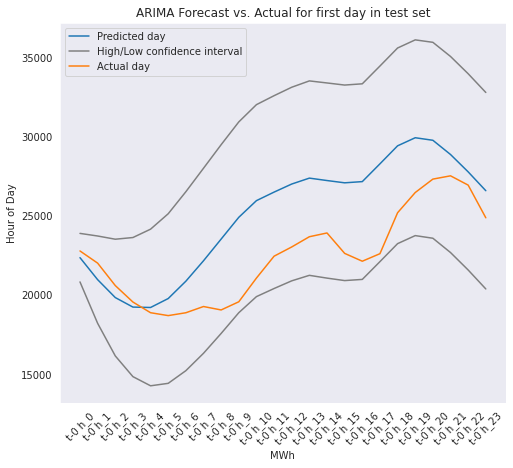

In [ ]:
#plot the result and get an idea if the forecast is in the right direction
fig = plt.figure(figsize=(8,7))

plt.plot(forecast_24, label='Predicted day')
plt.plot(intervals_24[:,0], label='High/Low confidence interval', color='gray')
plt.plot(intervals_24[:,1], color='gray')
plt.plot(test.iloc[0,:], label='Actual day')
plt.xticks(rotation=45)
plt.title('ARIMA Forecast vs. Actual for first day in test set')
plt.xlabel('MWh')
plt.ylabel('Hour of Day')
plt.legend()
plt.show()

Since it is computationally intensive, only 1 cycle is run for the test data.

In [ ]:
#calculate the root mean squared error of the single test run
print('ARIMA 1 step walk forward RMSE: {0:.2f} MWh' .format(mean_absolute_error(test.iloc[0,:], forecast_24)))

ARIMA 1 step walk forward RMSE: 2828.98 MWh


In [ ]:
#define a model to insert into the training rig created in the persistence workbook
def arima_model(history, config):
    
    #convert dataframe to numpy array and flatten into column vector
    history_flat = history.values.flatten()
    
    p,d,q = config
    
    #initalize the ARIMA model
    model = ARIMA(history_flat, order=(p, d, q))
    
    #fit model
    model_fit = model.fit()
    
    #generate forecast for the next 24 hours
    forecast, _, _ = model_fit.forecast(24)
    
    return forecast

In [ ]:
#train and test with a condensed training set
data = get_dataset(start='2017-01-01', stop='2018-03-31')
train_condensed, test_condensed = train_test_split(data, split_date='2017-12-31')
train_flat_condensed = train_condensed.values.flatten()

In [ ]:
print('Total days in train set {}'.format(train_condensed.shape[0]))
print('Total days in test set {}'.format(test_condensed.shape[0]))

Total days in train set 365
Total days in test set 90


In [ ]:
# ARIMA with 24 auroregressive features
%time forecast_ARMA, std_AMRA, intervals_AMRA = run_ARIMA(train_flat_condensed)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


CPU times: user 15min 30s, sys: 4min 19s, total: 19min 50s
Wall time: 11min 7s


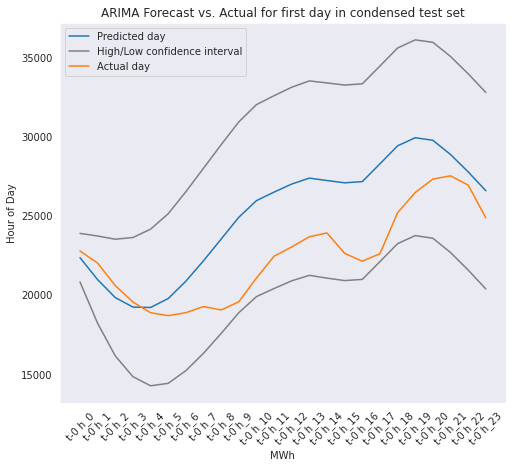

In [ ]:
#plot the result and get an idea if the forecast is in the right direction
fig = plt.figure(figsize=(8,7))

plt.plot(forecast_24, label='Predicted day')
plt.plot(intervals_24[:,0], label='High/Low confidence interval', color='gray')
plt.plot(intervals_24[:,1], color='gray')
plt.plot(test.iloc[0,:], label='Actual day')
plt.xticks(rotation=45)
plt.title('ARIMA Forecast vs. Actual for first day in condensed test set')
plt.xlabel('MWh')
plt.ylabel('Hour of Day')
plt.legend()
plt.show()

In [ ]:
print('ARIMA 1 step walk forward RMSE: {0:.2f} MWh' .format(np.sqrt(mean_squared_error(test_condensed.iloc[0,:], forecast_ARMA))))

ARIMA 1 step walk forward RMSE: 3393.71 MWh


But as we can see, original data showed less rmse thsn condensed data.So for only one cycle, it shows better results.

#3. Prophet

In [19]:
#Download required dependencies

!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 101 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.6 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6638089 sha256=b71703d4a0490c7ba6c6c9f119dd467dff3864b8cdda8af3ca97d3e01684c3d2
  Stored in directory: /root/.cache/pip/wheels/cd/a1/12/db63ff624de492fe6cccf676091a0860fdde2ffde4bc3280e2
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdstanpy-1.0.8
ERROR: pip's dependency resolver does not currently take into account all the 

In [20]:
!pip install --upgrade plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 5.3 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [17]:
#import libraries

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('dark')

from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from statsmodels.graphics.gofplots import qqplot

In [21]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [22]:
#load the dataset
data = get_dataset(index='time', start='2015-01-01', stop='2018-12-31', shift=0)
data.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0


In [23]:
#leave 6 months as a hold out test set
train, test = train_test_split(data, split_date='2018-06-30')

In [24]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2015-01-01 00:00:00'),
 Timestamp('2018-06-30 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-12-31 00:00:00'))

In [25]:
test.head(2)

,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2018-07-01,25450.0,23662.0,22130.0,21250.0,20994.0,20974.0,21423.0,22259.0,22981.0,24643.0,...,29679.0,28491.0,27811.0,28043.0,30461.0,31765.0,32899.0,32866.0,31471.0,28895.0
2018-07-02,29682.0,27419.0,26095.0,25574.0,25491.0,26150.0,28981.0,34156.0,37284.0,38717.0,...,37560.0,37095.0,36883.0,36827.0,37645.0,39948.0,40620.0,39824.0,36818.0,32993.0


###Adding holidays in Prophet

Holidays are added using a built-in feature from Prophet, also days of week are added to the data.

In [26]:
#import relevant libraries
from datetime import date
import pandas as pd
import holidays

In [ ]:
#create a datetime range
dates = pd.date_range(start='1/1/2018', end='31/12/2018')
dates

In [28]:
#produces categorical numerical values for the each day of the week
# Eg: monday = 0 and sunday = 6
dates.weekday

Int64Index([0, 1, 2, 3, 4, 5, 6, 0, 1, 2,
            ...
            5, 6, 0, 1, 2, 3, 4, 5, 6, 0],
           dtype='int64', length=365)

In [29]:
#object with all the holidays in Spain
spain_holidays = holidays.CountryHoliday('ES')

In [30]:
#Find some holiday dates is there or no
print(date(2019, 1, 1) in spain_holidays)
print(date(2018, 12, 25) in spain_holidays)
print(date(2018, 12, 5) in spain_holidays)

True
True
False


In [31]:
# get the name of the holiday
spain_holidays.get('2018-12-25')

'Navidad'

In [53]:
# finds the holiday exists or no with its name

def get_holidays(start='1/1/2018', stop='31/12/2018', country='ES', frequency='H'):
    
    #set range of daily dates
    dates = pd.date_range(start=start, end=stop, freq=frequency)
    
    #create the holiday object
    national_holidays = holidays.CountryHoliday(country)

    #create a list for the holiday bool and name
    holiday_list = []
    
    #loop through the dates
    for date in dates:
        #true if holiday in object, else false
        holiday_bool = date in national_holidays
        holiday_names = national_holidays.get(date)
        
        holiday_list.append([holiday_bool, holiday_names])
        
    #create return dataframe
    holidays_data = pd.DataFrame(holiday_list, index=dates, columns=['holiday_bool', 'holiday_name'])
                  
    return holidays_data


In [54]:
# Produces a dataframe with a date time index at the frequency input and columns

def get_days(start='1/1/2018', stop='31/12/2018', frequency='H'):
    
    #generate the range of daily dates
    dates = pd.date_range(start=start, end=stop, freq=frequency)
    
    #create a dataframe of weekday categories
    days = pd.DataFrame(list(dates.weekday), index=dates, columns=['weekday_id'])
    
    days = pd.get_dummies(days['weekday_id'])
    
    columns = ['mon', 'tue', 'wed', 'thur', 'fri', 'sat', 'sun']
    
    days.columns = columns
    
    return days

In [55]:
get_days()

,mon,tue,wed,thur,fri,sat,sun
2018-01-01 00:00:00,1,0,0,0,0,0,0
2018-01-01 01:00:00,1,0,0,0,0,0,0
2018-01-01 02:00:00,1,0,0,0,0,0,0
2018-01-01 03:00:00,1,0,0,0,0,0,0
2018-01-01 04:00:00,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2018-12-30 20:00:00,0,0,0,0,0,0,1
2018-12-30 21:00:00,0,0,0,0,0,0,1
2018-12-30 22:00:00,0,0,0,0,0,0,1
2018-12-30 23:00:00,0,0,0,0,0,0,1


In [56]:
holiday_df = get_holidays(start='2015-01-01', stop='2018-12-31')
holiday_df.head(5)

,holiday_bool,holiday_name
2015-01-01 00:00:00,True,Año nuevo
2015-01-01 01:00:00,True,Año nuevo
2015-01-01 02:00:00,True,Año nuevo
2015-01-01 03:00:00,True,Año nuevo
2015-01-01 04:00:00,True,Año nuevo


In [36]:
holiday_df.holiday_name.unique()

array(['Año nuevo', None, 'Epifanía del Señor', 'Jueves Santo',
       'Viernes Santo', 'Día del Trabajador', 'Asunción de la Virgen',
       'Día de la Hispanidad', 'Todos los Santos (Trasladado)',
       'Día de la Constitución Española (Trasladado)',
       'La Inmaculada Concepción', 'Navidad',
       'Día del Trabajador (Trasladado)', 'Todos los Santos',
       'Día de la Constitución Española', 'Navidad (Trasladado)',
       'Año nuevo (Trasladado)'], dtype=object)

In [57]:
# generate days of the week dataframe. 

days_df = get_days(start='2018-01-01', stop='2018-04-01', frequency='H')

days_df.tail(3)

,mon,tue,wed,thur,fri,sat,sun
2018-03-31 22:00:00,0,0,0,0,0,1,0
2018-03-31 23:00:00,0,0,0,0,0,1,0
2018-04-01 00:00:00,0,0,0,0,0,0,1


In [38]:
#holiday model initalize
holiday_model = Prophet(yearly_seasonality=False, 
                        seasonality_mode='additive',
                        holidays_prior_scale=35)

In [39]:
#add holidays for spain
holiday_model.add_country_holidays(country_name='ES')

###Adding weather feature in Prophet

Here, weather features like wind, temperature, rain, etc are added to the energy data in Prophet model.

In [41]:
data_comb1 = pd.read_csv('/content/gdrive/MyDrive/Project/Data_Project/Processed Data/energy_weather_2015_2018.csv', parse_dates=True, index_col='time')
data_comb1.head(3)

,actual_load,year,month,day,hours,date,temp,pressure,wind_speed,rain_1h,rain_3h,snow_3h,heatdd,cooldd
time,,,,,,,,,,,,,,
2015-01-01 00:00:00,25385.0,2015,1,1,0,2015-01-01,271.239327,998.190492,2.078209,0.0,0.0,0.0,19.910673,0.0
2015-01-01 01:00:00,24382.0,2015,1,1,1,2015-01-01,271.245271,998.134512,2.078209,0.0,0.0,0.0,19.904729,0.0
2015-01-01 02:00:00,22734.0,2015,1,1,2,2015-01-01,270.544537,998.507545,2.230083,0.0,0.0,0.0,20.605463,0.0


In [42]:
## slice for the date range 
data_comb1 = data_comb1['2017-01-01':'2018-06-30']

print(data_comb1.index.min(), data_comb1.index.max())

data_comb1.head(3)

2017-01-01 00:00:00 2018-06-30 23:00:00


,actual_load,year,month,day,hours,date,temp,pressure,wind_speed,rain_1h,rain_3h,snow_3h,heatdd,cooldd
time,,,,,,,,,,,,,,
2017-01-01 00:00:00,24401.0,2017,1,1,0,2017-01-01,274.912775,1030.016064,1.812104,0.0,0.0,0.0,16.237225,0.0
2017-01-01 01:00:00,23393.0,2017,1,1,1,2017-01-01,274.754913,1029.699010,1.740062,0.0,0.0,0.0,16.395087,0.0
2017-01-01 02:00:00,21909.0,2017,1,1,2,2017-01-01,273.994245,1028.827032,1.812104,0.0,0.0,0.0,17.155755,0.0


In [43]:
# apply PCA to the weather features to reduce dimensionality.

#initate a min max scaler
minmax = MinMaxScaler()

#initate a PCA object
pca = PCA(n_components=2)

#initate the pipeline for pca
pca_pipe = make_pipeline(pca, minmax)

minmax_pipe = make_pipeline(minmax)

In [58]:
# PCA of weather data

weather_cols = ['temp','pressure','wind_speed','rain_1h','rain_3h','snow_3h','heatdd','cooldd']

#selecting the weather columns and checking for Nans 
data_weather = data_comb1[weather_cols].interpolate(method='linear')

#transform the weather data
pca_weather = pca_pipe.fit_transform(data_weather)

# create new dataframe
pca_weather_df = pd.DataFrame(pca_weather, index=data_weather.index, columns=['pca1', 'pca2'])

In [45]:
pca_weather_df.head(3)

,pca1,pca2
time,,
2017-01-01 00:00:00,0.111137,0.093135
2017-01-01 01:00:00,0.106763,0.097269
2017-01-01 02:00:00,0.085853,0.108841


In [46]:
#slice out the energy data
energy_data = data_comb1['actual_load']

#apply minmax scaler i.e. reshape to 2d array
energy_minmax = minmax_pipe.fit_transform(np.reshape(energy_data.values, (-1,1)))

#convert back to dataframe
energy_minmax_df = pd.DataFrame(energy_minmax, index=energy_data.index, columns=['y'])

energy_minmax_df.head(3)

,y
time,
2017-01-01 00:00:00,0.255879
2017-01-01 01:00:00,0.210731
2017-01-01 02:00:00,0.144265


In [59]:
def standard_index(data):
    data = data.reset_index()
    data.sort_values(by=['ds'], inplace=True)
    
    return data

In [60]:
# Here rows are daily values and columns are hourly slices 
#splits data into a train and test.

def data_split(data, split_date):
    
    data.sort_index(ascending=True, inplace=True)
    
    #set the train data
    train = data.loc[:split_date,:]

    split_date = dt.datetime.strptime(split_date, '%Y-%m-%d')
    
    #increment the split date by 1
    split_date += dt.timedelta(days=1)
    
    #set test data
    test = data.loc[split_date:, :]
    
    print(train.index.min(), train.index.max())
    print(test.index.min(), test.index.max())
    
    return train, test

In [61]:
a, b = data_split(data_comb1, '2018-02-15')

2017-01-01 00:00:00 2018-02-15 23:00:00
2018-02-16 00:00:00 2018-06-30 23:00:00


In [62]:
#combine the energy and weather again as scaled features

data_scaled = pd.concat([energy_minmax_df,pca_weather_df], axis=1)

#adding 'ds' column
data_scaled.index.name='ds'

#split in train and test
train_energy_weather, test_energy_weather = train_test_split(data_scaled, '2018-03-31')

#change and order index for prophet 
train_energy_weather = standard_index(train_energy_weather)
#change and order index for prophet
test_energy_weather = standard_index(test_energy_weather)

print('Length of the train dataset {}' .format(len(train_energy_weather)))
print('Length of the test dataset {}' .format(len(test_energy_weather)))
train_energy_weather.head(3)

Length of the train dataset 10920
Length of the test dataset 2184


,ds,y,pca1,pca2
0,2017-01-01 00:00:00,0.255879,0.111137,0.093135
1,2017-01-01 01:00:00,0.210731,0.106763,0.097269
2,2017-01-01 02:00:00,0.144265,0.085853,0.108841


In [65]:
#function to process the fit, cross validation, and performance for model 

def prophet_performance(model, train, pipe):
    
    #fit the model
    model.fit(train)
    
    #run cross validation
    cross_val_results = cross_validation(model, initial='365 days', period='24 hours', horizon='24 hours')
    
    #inverse transform the target and prediction columns
    cross_val_results[['yhat', 'y']] = minmax_pipe.inverse_transform(cross_val_results[['yhat','y']])
    
    #get performance results on the cross validation output
    cross_val_performance = performance_metrics(cross_val_results)
    
    #display the results
    print('Model Mean Hourly MAE {0:.2f}' .format(np.mean(cross_val_performance['mae'])))
    print('Model Mean Hourly MAPE {0:.2f}' .format(np.mean(cross_val_performance['mape'])))
    
    return cross_val_results, cross_val_performance

In [63]:
def disp_prophet_results(crossvalidated):
    
    model_fig = plot_cross_validation_metric(crossvalidated, metric='mae', rolling_window=0)
    model_results = performance_metrics(crossvalidated)
    print('Base model MAE {0:.2f}' .format(np.mean(model_results['mae'])))
    
    #print(cv_model_results)
    
    return model_results

INFO:fbprophet:Making 89 forecasts with cutoffs between 2018-01-01 23:00:00 and 2018-03-30 23:00:00


  0%|          | 0/89 [00:00<?, ?it/s]

Model Mean Hourly MAE 17.16
Model Mean Hourly MAPE 3.04


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


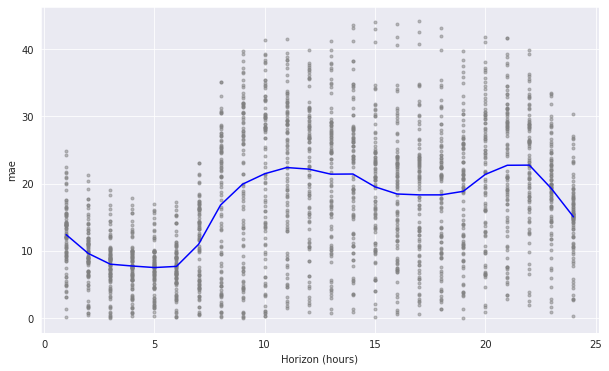

In [66]:
#weather base model initalize
base_model = Prophet(yearly_seasonality=True, 
                        seasonality_mode='additive')

#fit model, run cross validation, return results, performance, and mean MAE
base_results, base_perfomance_2017 = prophet_performance(base_model, train_energy_weather, minmax_pipe)

#plot the crossvalidated error performance
plot_cross_validation_metric(base_results, metric='mae', rolling_window=0);

In [67]:
base_results.to_csv('/content/gdrive/MyDrive/Project/Results/base_results.csv')
base_perfomance_2017.to_csv('/content/gdrive/MyDrive/Project/Results/base_performance.csv')

INFO:fbprophet:Making 89 forecasts with cutoffs between 2018-01-01 23:00:00 and 2018-03-30 23:00:00


  0%|          | 0/89 [00:00<?, ?it/s]

Model Mean Hourly MAE 17.15
Model Mean Hourly MAPE 3.06


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


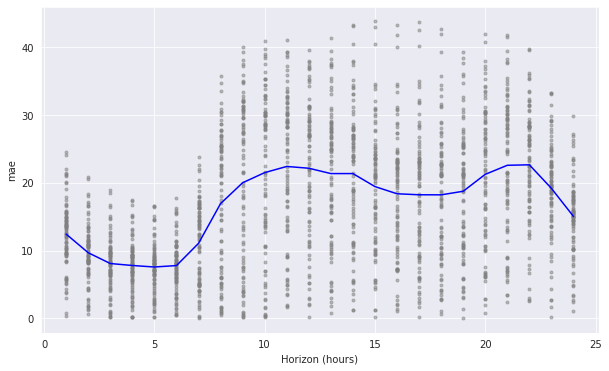

In [69]:
#Model with weather PCA regressors
weather_model = Prophet(yearly_seasonality=True, 
                        seasonality_mode='additive')

#add pca weather regressors
weather_model.add_regressor('pca1', prior_scale=0.8, mode='additive')
weather_model.add_regressor('pca2', prior_scale=0.8, mode='additive')

#fit model, run cross validation, return results, performance, and mean MAE
weather_model_results, weather_model_perfomance = prophet_performance(weather_model, train_energy_weather, minmax_pipe)

#plot the crossvalidated error performance
plot_cross_validation_metric(weather_model_results, metric='mae', rolling_window=0);

In [70]:
weather_model_results.to_csv('/content/gdrive/MyDrive/Project/Results/weather_model_results.csv')
weather_model_perfomance.to_csv('/content/gdrive/MyDrive/Project/Results/weather_model_performance.csv')

INFO:fbprophet:Making 424 forecasts with cutoffs between 2017-01-31 23:00:00 and 2018-03-30 23:00:00


  0%|          | 0/424 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
INFO:fbprophet:Skipping MAPE because y close to 0


Base model MAE 0.11


,horizon,mse,rmse,mae,mdape,coverage
0,0 days 03:00:00,0.008738,0.093478,0.071455,0.221602,0.899376
1,0 days 04:00:00,0.008779,0.093696,0.071614,0.247040,0.894645
2,0 days 05:00:00,0.008913,0.094408,0.072178,0.295414,0.890526
3,0 days 06:00:00,0.009228,0.096063,0.073687,0.286744,0.884626
4,0 days 07:00:00,0.011083,0.105274,0.081001,0.279847,0.841953
5,0 days 08:00:00,0.018296,0.135263,0.105943,0.266568,0.735766
6,0 days 09:00:00,0.028137,0.167740,0.134752,0.260346,0.623527
7,0 days 10:00:00,0.032446,0.180127,0.144891,0.233685,0.586061
8,0 days 11:00:00,0.030303,0.174078,0.137351,0.189283,0.616192
9,0 days 12:00:00,0.026720,0.163463,0.127469,0.168968,0.659429


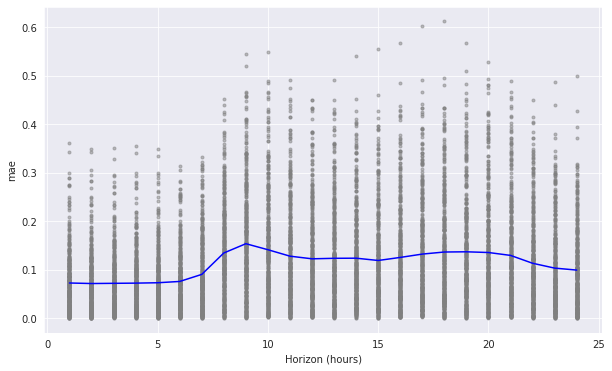

In [71]:
#run cross validator
weather_prophet_model = cross_validation(weather_model, initial='30 days', period='24 hours', horizon='24 hours')

#the results below are for the holiday_model 
disp_prophet_results(weather_prophet_model)